# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда.



In [35]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)

    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3,
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False)

    return train_loader, val_loader, test_loader


In [ ]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64,
                                                         transform_train=transform)

100%|██████████| 170M/170M [00:03<00:00, 47.5MB/s]


Посмотрим на изображения:

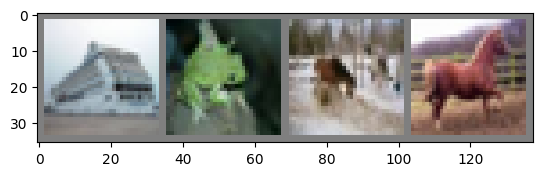

ship frog horse horse


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [ ]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        self.n_classes = n_classes

        self.net1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=32)
        )

        self.net2 = nn.Conv2d(3, 32, kernel_size=1)
        self.activation = nn.ReLU()
        self.pooling = nn.AvgPool2d(kernel_size=8, stride=8)
        self.flatten = nn.Flatten()
        self.net3 = nn.Linear(512, self.n_classes)

    def forward(self, x):
        out1 = self.net1(x)
        out2 = self.net2(x)
        out = self.activation(out1 + out2)
        out = self.pooling(out)
        out = self.flatten(out)
        out = self.net3(out)
        return out

In [ ]:
net = BasicBlockNet()
net

BasicBlockNet(
  (net1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (net2): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (activation): ReLU()
  (pooling): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (net3): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [ ]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [ ]:
from tqdm import tqdm

In [ ]:
criterion = nn.CrossEntropyLoss()

def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    with torch.inference_mode():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            out = model(data)
            loss = criterion(out, target)

            loss_log.append(loss.item())

            acc = (out.argmax(dim=1) == target).float().mean()

            acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()

        loss_log.append(loss.item())

        acc = (out.argmax(dim=1) == target).float().mean()

        acc_log.append(acc.item())

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in tqdm(range(n_epochs), leave=True):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        tqdm.write(f"Epoch {epoch}")
        tqdm.write(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        tqdm.write(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

  5%|▌         | 1/20 [00:15<05:01, 15.86s/it]

Epoch 0
 train loss: 0.9131660846077327, train acc: 0.6834682684929759
 val loss: 0.9770427592257236, val acc: 0.6681959220703612



 10%|█         | 2/20 [00:31<04:44, 15.78s/it]

Epoch 1
 train loss: 0.8936886693158577, train acc: 0.6896831745203496
 val loss: 0.9126443355641467, val acc: 0.6881427305809995



 15%|█▌        | 3/20 [00:47<04:30, 15.90s/it]

Epoch 2
 train loss: 0.8754326530086929, train acc: 0.6955961087068212
 val loss: 0.9114859433884316, val acc: 0.6837322696726373



 20%|██        | 4/20 [01:03<04:15, 15.94s/it]

Epoch 3
 train loss: 0.8691348308183158, train acc: 0.6980078023138169
 val loss: 0.9311461136696186, val acc: 0.6811391845662543



 25%|██▌       | 5/20 [01:19<03:58, 15.88s/it]

Epoch 4
 train loss: 0.8480627008286429, train acc: 0.703112757946935
 val loss: 0.9218314454910603, val acc: 0.6793218085106383



 30%|███       | 6/20 [01:35<03:42, 15.89s/it]

Epoch 5
 train loss: 0.8321960762933142, train acc: 0.7109191368659192
 val loss: 0.8855778635816371, val acc: 0.6940159574468086



 35%|███▌      | 7/20 [01:51<03:29, 16.13s/it]

Epoch 6
 train loss: 0.8236198375168404, train acc: 0.7141020828670732
 val loss: 0.9188889320860518, val acc: 0.6852615249917863



 40%|████      | 8/20 [02:07<03:12, 16.01s/it]

Epoch 7
 train loss: 0.8180682501692659, train acc: 0.7173911269883569
 val loss: 0.9486868640209766, val acc: 0.6827349292471053



 45%|████▌     | 9/20 [02:23<02:55, 15.91s/it]

Epoch 8
 train loss: 0.8024786579979403, train acc: 0.7202639397798988
 val loss: 0.8741429359354871, val acc: 0.6995789007937655



 50%|█████     | 10/20 [02:39<02:39, 15.98s/it]

Epoch 9
 train loss: 0.7976956330444085, train acc: 0.7224022264454439
 val loss: 0.9333168460967692, val acc: 0.680186170212766



 55%|█████▌    | 11/20 [02:55<02:23, 15.90s/it]

Epoch 10
 train loss: 0.7853702450583142, train acc: 0.7263482633630798
 val loss: 0.870260027368018, val acc: 0.7012189718002969



 60%|██████    | 12/20 [03:10<02:06, 15.81s/it]

Epoch 11
 train loss: 0.7861995908961218, train acc: 0.7260993406367259
 val loss: 0.8816289610051095, val acc: 0.6990248228641267



 65%|██████▌   | 13/20 [03:26<01:51, 15.87s/it]

Epoch 12
 train loss: 0.7707268791835095, train acc: 0.7314572995715865
 val loss: 0.8748919806581863, val acc: 0.698470744680851



 70%|███████   | 14/20 [03:42<01:34, 15.81s/it]

Epoch 13
 train loss: 0.7619026587693739, train acc: 0.733832267019387
 val loss: 0.8752414152977315, val acc: 0.7025265957446809



 75%|███████▌  | 15/20 [03:58<01:18, 15.72s/it]

Epoch 14
 train loss: 0.7578274501416103, train acc: 0.7359379081011255
 val loss: 0.9006458548789329, val acc: 0.692442376055616



 80%|████████  | 16/20 [04:13<01:02, 15.67s/it]

Epoch 15
 train loss: 0.7501685909749821, train acc: 0.7403246605635997
 val loss: 0.8871642206577545, val acc: 0.6990248228641267



 85%|████████▌ | 17/20 [04:29<00:47, 15.89s/it]

Epoch 16
 train loss: 0.7456418127638766, train acc: 0.739932913339988
 val loss: 0.8720413651872189, val acc: 0.7013076241980207



 90%|█████████ | 18/20 [04:45<00:31, 15.79s/it]

Epoch 17
 train loss: 0.7342202625828208, train acc: 0.7459723492862973
 val loss: 0.881604438386065, val acc: 0.701817376055616



 95%|█████████▌| 19/20 [05:01<00:15, 15.76s/it]

Epoch 18
 train loss: 0.7326076201263686, train acc: 0.7433974276513025
 val loss: 0.8542464618987226, val acc: 0.7100620569066799



100%|██████████| 20/20 [05:17<00:00, 15.85s/it]

Epoch 19
 train loss: 0.7243856804026546, train acc: 0.7485595129743573
 val loss: 0.8361915791288336, val acc: 0.714095744680851



In [ ]:
torch.save(net.state_dict(), "model_1_weights.pth")

Посчитайте точность на тестовой выборке:

In [ ]:
_, test_acc = test(net, test_loader)
print(f'Test accuracy: {test_acc:.4f}')

Test accuracy: 0.7076


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

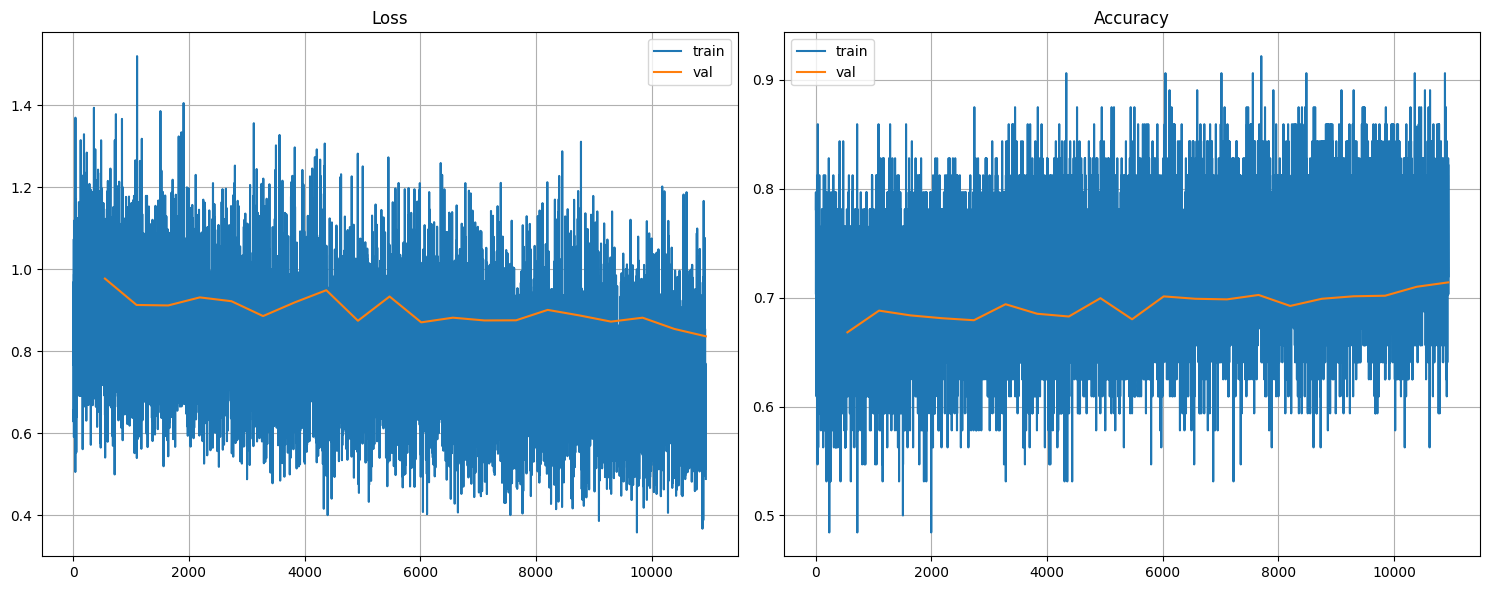

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))

ax[0].plot(range(1, 20 * len(train_loader) + 1), train_loss_log, label='train')
ax[0].plot(len(train_loader) * np.arange(1, 21), val_loss_log, label='val')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].grid()

ax[1].plot(range(1, 20 * len(train_loader) + 1), train_acc_log, label='train')
ax[1].plot(len(train_loader) * np.arange(1, 21), val_acc_log, label='val')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

  5%|▌         | 1/20 [00:15<05:00, 15.83s/it]

Epoch 0
 train loss: 1.5179664580869936, train acc: 0.4549980413107375
 val loss: 1.3202206345314675, val acc: 0.5342198582405739



 10%|█         | 2/20 [00:32<04:50, 16.15s/it]

Epoch 1
 train loss: 1.2062958448417007, train acc: 0.5766518673905506
 val loss: 1.1332465564950984, val acc: 0.610283688027808



 15%|█▌        | 3/20 [00:47<04:29, 15.87s/it]

Epoch 2
 train loss: 1.0818516916069296, train acc: 0.6232412183960352
 val loss: 1.0159458099527563, val acc: 0.6482491135597229



 20%|██        | 4/20 [01:03<04:12, 15.75s/it]

Epoch 3
 train loss: 1.0220685693855913, train acc: 0.6460482502114402
 val loss: 0.9890559551563669, val acc: 0.6592641845662544



 25%|██▌       | 5/20 [01:19<03:59, 15.99s/it]

Epoch 4
 train loss: 0.9678459486752149, train acc: 0.6639053930530164
 val loss: 0.9754132958168679, val acc: 0.6639627659574469



 30%|███       | 6/20 [01:35<03:42, 15.86s/it]

Epoch 5
 train loss: 0.9398102771211586, train acc: 0.6742173218639939
 val loss: 1.0002944530324733, val acc: 0.6537677305809995



 35%|███▌      | 7/20 [01:50<03:25, 15.79s/it]

Epoch 6
 train loss: 0.9072212794799037, train acc: 0.6844476365520051
 val loss: 0.9705498578700613, val acc: 0.6722517731341909



 40%|████      | 8/20 [02:06<03:09, 15.77s/it]

Epoch 7
 train loss: 0.8878076610443143, train acc: 0.6910746932247657
 val loss: 0.9554536641912258, val acc: 0.6699024824385947



 45%|████▌     | 9/20 [02:22<02:54, 15.89s/it]

Epoch 8
 train loss: 0.875216287603326, train acc: 0.6937842778793418
 val loss: 0.9131573750617656, val acc: 0.6854831561129144



 50%|█████     | 10/20 [02:38<02:38, 15.82s/it]

Epoch 9
 train loss: 0.8651313001538543, train acc: 0.6983587425849119
 val loss: 0.9417440962284169, val acc: 0.6799645390916378



 55%|█████▌    | 11/20 [02:54<02:21, 15.78s/it]

Epoch 10
 train loss: 0.7578751994007467, train acc: 0.738390408769604
 val loss: 0.8395549738660771, val acc: 0.7130319148936171



 60%|██████    | 12/20 [03:10<02:07, 15.95s/it]

Epoch 11
 train loss: 0.7408963603119092, train acc: 0.7442380517884626
 val loss: 0.8360939345461257, val acc: 0.7154255319148937



 65%|██████▌   | 13/20 [03:26<01:50, 15.84s/it]

Epoch 12
 train loss: 0.734952082527185, train acc: 0.7452745495374286
 val loss: 0.8316058891884824, val acc: 0.7170877659574468



 70%|███████   | 14/20 [03:41<01:34, 15.77s/it]

Epoch 13
 train loss: 0.7300593327778567, train acc: 0.7469557979207152
 val loss: 0.832861633630509, val acc: 0.7150265957446809



 75%|███████▌  | 15/20 [03:57<01:18, 15.75s/it]

Epoch 14
 train loss: 0.7269323628933818, train acc: 0.7492736354606461
 val loss: 0.8288072668491526, val acc: 0.719281914893617



 80%|████████  | 16/20 [04:13<01:03, 15.84s/it]

Epoch 15
 train loss: 0.7128461105187153, train acc: 0.755047825834215
 val loss: 0.822433761206079, val acc: 0.7206117021276596



 85%|████████▌ | 17/20 [04:29<00:47, 15.75s/it]

Epoch 16
 train loss: 0.7110030985619512, train acc: 0.7574268739663704
 val loss: 0.8220172496552163, val acc: 0.7204122340425532



 90%|█████████ | 18/20 [04:44<00:31, 15.70s/it]

Epoch 17
 train loss: 0.7105330870073064, train acc: 0.7550723100493115
 val loss: 0.822952948732579, val acc: 0.7222739361702127



 95%|█████████▌| 19/20 [05:00<00:15, 15.87s/it]

Epoch 18
 train loss: 0.7103697447279907, train acc: 0.7551743275940527
 val loss: 0.8214846332022484, val acc: 0.7188164893617022



100%|██████████| 20/20 [05:16<00:00, 15.83s/it]

Epoch 19
 train loss: 0.7085316706945953, train acc: 0.7559945483094378
 val loss: 0.8208569394781234, val acc: 0.7203457446808511



Посчитайте точность на тестовой выборке:

In [ ]:
_, test_acc = test(net, test_loader)
print(f'Test accuracy: {test_acc:.4f}')

Test accuracy: 0.7153


Качество улучшилось практически на процент

**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

  5%|▌         | 1/20 [00:15<04:59, 15.77s/it]

Epoch 0
 train loss: 1.8337296722575995, train acc: 0.3570612431444241
 val loss: 1.6149448176647754, val acc: 0.4371453901554676



 10%|█         | 2/20 [00:31<04:42, 15.72s/it]

Epoch 1
 train loss: 1.5306552376128202, train acc: 0.465591538322909
 val loss: 1.4449876861369355, val acc: 0.4923537234042553



 15%|█▌        | 3/20 [00:47<04:32, 16.02s/it]

Epoch 2
 train loss: 1.410147892491691, train acc: 0.5070718530109203
 val loss: 1.3658867526561655, val acc: 0.5220744680851064



 20%|██        | 4/20 [01:03<04:15, 15.95s/it]

Epoch 3
 train loss: 1.3354244372744446, train acc: 0.5330455079810928
 val loss: 1.2833478810939383, val acc: 0.5477171986661059



 25%|██▌       | 5/20 [01:19<03:56, 15.80s/it]

Epoch 4
 train loss: 1.2792698205933928, train acc: 0.5538407547818242
 val loss: 1.2544935218831326, val acc: 0.5607491135597229



 30%|███       | 6/20 [01:34<03:39, 15.67s/it]

Epoch 5
 train loss: 1.2336287967029829, train acc: 0.5692209128487916
 val loss: 1.217974296782879, val acc: 0.5693927305809995



 35%|███▌      | 7/20 [01:50<03:24, 15.72s/it]

Epoch 6
 train loss: 1.2012894543694839, train acc: 0.5789533820840951
 val loss: 1.2077150126720997, val acc: 0.5757535462683819



 40%|████      | 8/20 [02:06<03:08, 15.68s/it]

Epoch 7
 train loss: 1.1702100764244958, train acc: 0.5915953904880684
 val loss: 1.1580904001885273, val acc: 0.5919991135597229



 45%|████▌     | 9/20 [02:21<02:52, 15.64s/it]

Epoch 8
 train loss: 1.1439328239430457, train acc: 0.5997608710468578
 val loss: 1.1278681143801264, val acc: 0.6021054965384462



 50%|█████     | 10/20 [02:38<02:39, 15.91s/it]

Epoch 9
 train loss: 1.1128615303274918, train acc: 0.6113051711096407
 val loss: 1.108396716828042, val acc: 0.6124335106382979



 55%|█████▌    | 11/20 [02:53<02:21, 15.77s/it]

Epoch 10
 train loss: 1.0897862829499532, train acc: 0.6174098982235632
 val loss: 1.1175409895308475, val acc: 0.6048537234042554



 60%|██████    | 12/20 [03:08<02:05, 15.65s/it]

Epoch 11
 train loss: 1.0706872114097832, train acc: 0.6280972513027994
 val loss: 1.0571173246870649, val acc: 0.6309175531914893



 65%|██████▌   | 13/20 [03:24<01:49, 15.59s/it]

Epoch 12
 train loss: 1.044438285736105, train acc: 0.6359321951212351
 val loss: 1.0524351333050017, val acc: 0.6314273050490846



 70%|███████   | 14/20 [03:40<01:34, 15.76s/it]

Epoch 13
 train loss: 1.0268477641686224, train acc: 0.6396497127342922
 val loss: 1.0284236715195028, val acc: 0.6428413122258287



 75%|███████▌  | 15/20 [03:55<01:18, 15.67s/it]

Epoch 14
 train loss: 1.0102657062262024, train acc: 0.6477417407567584
 val loss: 1.0915519387164014, val acc: 0.6150930851063829



 80%|████████  | 16/20 [04:11<01:02, 15.62s/it]

Epoch 15
 train loss: 0.9977530628933113, train acc: 0.6538995168762626
 val loss: 1.027803833941196, val acc: 0.6392730497299357



 85%|████████▌ | 17/20 [04:27<00:47, 15.80s/it]

Epoch 16
 train loss: 0.9806024524803789, train acc: 0.6581107992576725
 val loss: 1.00595638092528, val acc: 0.6499113476022761



 90%|█████████ | 18/20 [04:43<00:31, 15.77s/it]

Epoch 17
 train loss: 0.9704837595305016, train acc: 0.6604286367976033
 val loss: 0.9661859174992176, val acc: 0.6647828015875309



 95%|█████████▌| 19/20 [04:59<00:15, 15.74s/it]

Epoch 18
 train loss: 0.9584933645764478, train acc: 0.6668353356434614
 val loss: 0.9567071207026218, val acc: 0.6668439718002969



100%|██████████| 20/20 [05:14<00:00, 15.73s/it]

Epoch 19
 train loss: 0.9470896875618581, train acc: 0.6704712392425188
 val loss: 0.9725088193061504, val acc: 0.6593306739279564



In [ ]:
_, test_acc = test(net, test_loader)
print(f'Test accuracy: {test_acc:.4f}')

Test accuracy: 0.6579


**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

__Косинусное расписание:__ $$\eta_t = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min})\left(1 + \cos \left(\pi \frac{t}{T_{max}} \right)\right)$$

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

  5%|▌         | 1/20 [00:17<05:26, 17.16s/it]

Epoch 0
 train loss: 1.488499021726291, train acc: 0.47037411858438355
 val loss: 1.2783280121519212, val acc: 0.5535682624958931



 10%|█         | 2/20 [00:32<04:44, 15.83s/it]

Epoch 1
 train loss: 1.1729562280382928, train acc: 0.5918279903680359
 val loss: 1.1736877826934164, val acc: 0.6021498227373082



 15%|█▌        | 3/20 [00:49<04:40, 16.50s/it]

Epoch 2
 train loss: 1.059557610608542, train acc: 0.6332062876202724
 val loss: 1.0362105483704425, val acc: 0.6432845744680851



 20%|██        | 4/20 [01:05<04:19, 16.19s/it]

Epoch 3
 train loss: 1.008891890210251, train acc: 0.6506145534393338
 val loss: 0.9871866626942412, val acc: 0.6587544327086591



 25%|██▌       | 5/20 [01:20<03:56, 15.74s/it]

Epoch 4
 train loss: 0.9681660867478338, train acc: 0.6639462001144995
 val loss: 1.0011331492281974, val acc: 0.6596187944107867



 30%|███       | 6/20 [01:34<03:36, 15.43s/it]

Epoch 5
 train loss: 0.9339252022219314, train acc: 0.675637405358895
 val loss: 0.9681556800578502, val acc: 0.6633865249917862



 35%|███▌      | 7/20 [01:50<03:20, 15.44s/it]

Epoch 6
 train loss: 0.901556768626574, train acc: 0.6858187517256797
 val loss: 0.9288285237677554, val acc: 0.6798758866939139



 40%|████      | 8/20 [02:05<03:03, 15.25s/it]

Epoch 7
 train loss: 0.8753236176980697, train acc: 0.6943841407678245
 val loss: 0.9179868994875157, val acc: 0.6869459220703612



 45%|████▌     | 9/20 [02:20<02:46, 15.17s/it]

Epoch 8
 train loss: 0.8479044040225759, train acc: 0.705781535757961
 val loss: 0.9199392661135247, val acc: 0.6830230497299357



 50%|█████     | 10/20 [02:35<02:31, 15.11s/it]

Epoch 9
 train loss: 0.8313677569738908, train acc: 0.710539631804339
 val loss: 0.9200530858750039, val acc: 0.6879875888215735



 55%|█████▌    | 11/20 [02:50<02:17, 15.26s/it]

Epoch 10
 train loss: 0.8083856410910486, train acc: 0.7199823714697383
 val loss: 0.8881704751481401, val acc: 0.6975842199427016



 60%|██████    | 12/20 [03:05<02:01, 15.18s/it]

Epoch 11
 train loss: 0.7870503209626653, train acc: 0.7263645861004998
 val loss: 0.8806904526467019, val acc: 0.7011746454746165



 65%|██████▌   | 13/20 [03:20<01:45, 15.09s/it]

Epoch 12
 train loss: 0.7684370409527034, train acc: 0.7311675698927159
 val loss: 0.8385255088197424, val acc: 0.7158687944107868



 70%|███████   | 14/20 [03:35<01:30, 15.05s/it]

Epoch 13
 train loss: 0.7499986038674384, train acc: 0.7399247519712779
 val loss: 0.8579463494584916, val acc: 0.7064051420130628



 75%|███████▌  | 15/20 [03:50<01:15, 15.16s/it]

Epoch 14
 train loss: 0.7329652931071287, train acc: 0.7467231980407478
 val loss: 0.8174739402659396, val acc: 0.7234264186088075



 80%|████████  | 16/20 [04:05<01:00, 15.09s/it]

Epoch 15
 train loss: 0.7173845544593643, train acc: 0.7525912444813814
 val loss: 0.8238201616926396, val acc: 0.7228280143534883



 85%|████████▌ | 17/20 [04:20<00:45, 15.01s/it]

Epoch 16
 train loss: 0.7066663041629129, train acc: 0.7575982633630798
 val loss: 0.8198941237114845, val acc: 0.7189937944107867



 90%|█████████ | 18/20 [04:35<00:29, 14.98s/it]

Epoch 17
 train loss: 0.6944634521574163, train acc: 0.7621441630602319
 val loss: 0.8035283182529693, val acc: 0.7277925531914894



 95%|█████████▌| 19/20 [04:51<00:15, 15.28s/it]

Epoch 18
 train loss: 0.6865890880389449, train acc: 0.7646578742119686
 val loss: 0.8021595286562088, val acc: 0.7279698582405739



100%|██████████| 20/20 [05:06<00:00, 15.34s/it]

Epoch 19
 train loss: 0.6836367491394336, train acc: 0.7646497128432586
 val loss: 0.7987225027794533, val acc: 0.7289007093044038



In [ ]:
_, test_acc = test(net, test_loader)
print(f'test accuracy: {test_acc:.4f}')

test accuracy: 0.7218


__Экспоненциальное расписание:__ $$\eta_t = \gamma^t \eta_0$$

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.75)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

  5%|▌         | 1/20 [00:15<04:51, 15.37s/it]

Epoch 0
 train loss: 1.5185230520351278, train acc: 0.4569853422192812
 val loss: 1.3172165480065854, val acc: 0.530673758907521



 10%|█         | 2/20 [00:30<04:32, 15.13s/it]

Epoch 1
 train loss: 1.1982177190850378, train acc: 0.5769864848152593
 val loss: 1.1671176403126817, val acc: 0.5906914893617021



 15%|█▌        | 3/20 [00:48<04:44, 16.74s/it]

Epoch 2
 train loss: 1.0554624527856244, train acc: 0.6301212784795046
 val loss: 1.061230015247426, val acc: 0.631161347602276



 20%|██        | 4/20 [01:05<04:29, 16.84s/it]

Epoch 3
 train loss: 0.9739877480257582, train acc: 0.6589024549646395
 val loss: 0.9850954352541172, val acc: 0.6568262412192973



 25%|██▌       | 5/20 [01:21<04:05, 16.34s/it]

Epoch 4
 train loss: 0.9291735104058735, train acc: 0.6784734918822753
 val loss: 0.9562309767337556, val acc: 0.6675088654173181



 30%|███       | 6/20 [01:36<03:41, 15.84s/it]

Epoch 5
 train loss: 0.8896898270960918, train acc: 0.69253558378115
 val loss: 0.9456848451431762, val acc: 0.675221631374765



 35%|███▌      | 7/20 [01:51<03:21, 15.47s/it]

Epoch 6
 train loss: 0.868089034526832, train acc: 0.6978119287020109
 val loss: 0.9190855807446419, val acc: 0.6835106382978723



 40%|████      | 8/20 [02:05<03:03, 15.26s/it]

Epoch 7
 train loss: 0.844306161569285, train acc: 0.7082299556331181
 val loss: 0.886767015558608, val acc: 0.6940159574468086



 45%|████▌     | 9/20 [02:21<02:48, 15.32s/it]

Epoch 8
 train loss: 0.8286043096068136, train acc: 0.712918679827528
 val loss: 0.8943380424316894, val acc: 0.6928413122258288



 50%|█████     | 10/20 [02:36<02:31, 15.15s/it]

Epoch 9
 train loss: 0.8137618390472106, train acc: 0.7187091930474834
 val loss: 0.8713717290695677, val acc: 0.6967641845662543



 55%|█████▌    | 11/20 [02:51<02:18, 15.34s/it]

Epoch 10
 train loss: 0.8018293384006298, train acc: 0.7249526639743087
 val loss: 0.8595992940537474, val acc: 0.7028812058428501



 60%|██████    | 12/20 [03:06<02:01, 15.20s/it]

Epoch 11
 train loss: 0.7930423595024855, train acc: 0.7281437712352062
 val loss: 0.859573773120312, val acc: 0.7027482271194458



 65%|██████▌   | 13/20 [03:22<01:46, 15.24s/it]

Epoch 12
 train loss: 0.7862598590375737, train acc: 0.7285640833582695
 val loss: 0.8554769680855122, val acc: 0.7043218085106383



 70%|███████   | 14/20 [03:36<01:30, 15.09s/it]

Epoch 13
 train loss: 0.7839536353591591, train acc: 0.7286538587409792
 val loss: 0.852462980341404, val acc: 0.7059175531914894



 75%|███████▌  | 15/20 [03:51<01:15, 15.04s/it]

Epoch 14
 train loss: 0.7777570691470472, train acc: 0.732759042893293
 val loss: 0.850182465796775, val acc: 0.7059618795171697



 80%|████████  | 16/20 [04:06<00:59, 14.97s/it]

Epoch 15
 train loss: 0.7738170212975803, train acc: 0.733069176102905
 val loss: 0.847915492159255, val acc: 0.7073359930768927



 85%|████████▌ | 17/20 [04:22<00:46, 15.34s/it]

Epoch 16
 train loss: 0.7725279081129287, train acc: 0.7345178246062242
 val loss: 0.8466918405066145, val acc: 0.707779255319149



 90%|█████████ | 18/20 [04:37<00:30, 15.20s/it]

Epoch 17
 train loss: 0.7699751887722469, train acc: 0.7350401541650622
 val loss: 0.8456510200145396, val acc: 0.7055851063829788



 95%|█████████▌| 19/20 [04:52<00:15, 15.10s/it]

Epoch 18
 train loss: 0.7681232476692095, train acc: 0.7362562026794476
 val loss: 0.8442868935300949, val acc: 0.7086657803109352



100%|██████████| 20/20 [05:07<00:00, 15.37s/it]

Epoch 19
 train loss: 0.7683534174340299, train acc: 0.7350891225952553
 val loss: 0.8440179486223992, val acc: 0.7081338654173182



In [ ]:
_, test_acc = test(net, test_loader)
print(f'test accuracy: {test_acc:.4f}')

test accuracy: 0.7050


__Вывод:__ косинусное расписание показало лучший результат, в то время как экспоненциальное затухание показало качество примерно такое же, как и обучение с фиксированным lr

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

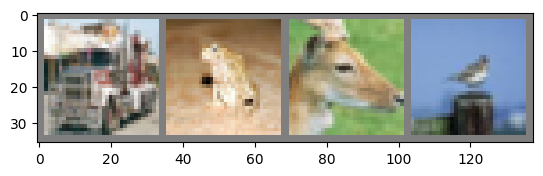

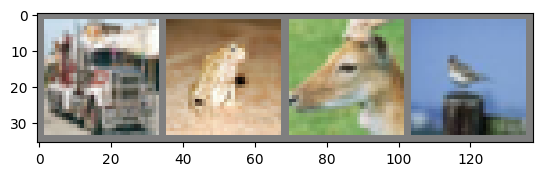

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [ ]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

  5%|▌         | 1/20 [00:18<05:47, 18.29s/it]

Epoch 0
 train loss: 1.4864023490187455, train acc: 0.47022313271841576
 val loss: 1.2572403593266264, val acc: 0.5500443263256803



 10%|█         | 2/20 [00:36<05:25, 18.08s/it]

Epoch 1
 train loss: 1.1521775393425002, train acc: 0.5983163032278936
 val loss: 1.1060570990785639, val acc: 0.6096852837724889



 15%|█▌        | 3/20 [00:54<05:08, 18.13s/it]

Epoch 2
 train loss: 1.0506304482873223, train acc: 0.6354588339925902
 val loss: 1.0161174507851296, val acc: 0.6492021276595744



 20%|██        | 4/20 [01:12<04:49, 18.08s/it]

Epoch 3
 train loss: 0.989804809773426, train acc: 0.6572008031595777
 val loss: 1.0767002491240805, val acc: 0.6313829787234042



 25%|██▌       | 5/20 [01:30<04:31, 18.07s/it]

Epoch 4
 train loss: 0.9539921237956017, train acc: 0.6720423087123543
 val loss: 0.9741166297425615, val acc: 0.667974290949233



 30%|███       | 6/20 [01:48<04:12, 18.07s/it]

Epoch 5
 train loss: 0.9233057476048931, train acc: 0.684031405113297
 val loss: 0.9514339223821112, val acc: 0.667686170212766



 35%|███▌      | 7/20 [02:07<03:57, 18.24s/it]

Epoch 6
 train loss: 0.9051408338372406, train acc: 0.6861248041419704
 val loss: 0.922302996097727, val acc: 0.6802304965384462



 40%|████      | 8/20 [02:24<03:36, 18.07s/it]

Epoch 7
 train loss: 0.8869142303519101, train acc: 0.6933843692870201
 val loss: 0.9357578964943581, val acc: 0.6770611702127659



 45%|████▌     | 9/20 [02:42<03:18, 18.06s/it]

Epoch 8
 train loss: 0.86734957527199, train acc: 0.700729629239391
 val loss: 0.9172966089654476, val acc: 0.6886746454746165



 50%|█████     | 10/20 [03:00<02:59, 17.95s/it]

Epoch 9
 train loss: 0.8507019071082093, train acc: 0.7069894229036363
 val loss: 0.9138707297913572, val acc: 0.6839760638297873



 55%|█████▌    | 11/20 [03:18<02:40, 17.83s/it]

Epoch 10
 train loss: 0.7623059170446622, train acc: 0.7367214025483488
 val loss: 0.791628224925792, val acc: 0.7301418441407224



 60%|██████    | 12/20 [03:36<02:23, 17.89s/it]

Epoch 11
 train loss: 0.7450421315224559, train acc: 0.7425119156593378
 val loss: 0.7865947756361454, val acc: 0.7316489361702128



 65%|██████▌   | 13/20 [03:53<02:04, 17.73s/it]

Epoch 12
 train loss: 0.740439354992, train acc: 0.7464865174764254
 val loss: 0.7904649624165069, val acc: 0.729654255319149



 70%|███████   | 14/20 [04:11<01:46, 17.83s/it]

Epoch 13
 train loss: 0.7363395113395816, train acc: 0.7470618961498114
 val loss: 0.7867115505198214, val acc: 0.7311170212765957



 75%|███████▌  | 15/20 [04:28<01:28, 17.67s/it]

Epoch 14
 train loss: 0.7318361520876179, train acc: 0.7475719835466179
 val loss: 0.7804979297708958, val acc: 0.7319148936170212



 80%|████████  | 16/20 [04:46<01:11, 17.76s/it]

Epoch 15
 train loss: 0.7175386443979344, train acc: 0.7543541068786677
 val loss: 0.7676263943631598, val acc: 0.7375664893617021



 85%|████████▌ | 17/20 [05:04<00:52, 17.65s/it]

Epoch 16
 train loss: 0.7176883484916233, train acc: 0.7519383324783506
 val loss: 0.7699470082496075, val acc: 0.7381870569066799



 90%|█████████ | 18/20 [05:22<00:35, 17.81s/it]

Epoch 17
 train loss: 0.7169761108523967, train acc: 0.7544030753088607
 val loss: 0.773413670443474, val acc: 0.7381205675449777



 95%|█████████▌| 19/20 [05:40<00:17, 17.85s/it]

Epoch 18
 train loss: 0.7160286220161745, train acc: 0.7538970684874429
 val loss: 0.7670521427976325, val acc: 0.739849290949233



100%|██████████| 20/20 [05:58<00:00, 17.90s/it]

Epoch 19
 train loss: 0.715972090443048, train acc: 0.7539337947556044
 val loss: 0.767893947185354, val acc: 0.7397384752618505



Посчитайте точность на тестовой выборке:

In [ ]:
_, test_acc = test(net, test_loader)
print(f'test accuracy: {test_acc:.4f}')

test accuracy: 0.7270


**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

__RandomResizedCrop:__ вырезается случайная область изображения, а затем скейлится до прежнего размера

In [ ]:
transform = transforms.Compose(
        [transforms.RandomResizedCrop(size=32, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

  5%|▌         | 1/20 [00:31<09:50, 31.08s/it]

Epoch 0
 train loss: 1.5354585165951327, train acc: 0.45182325678726
 val loss: 1.3339734820609397, val acc: 0.5218528369639782



 10%|█         | 2/20 [00:55<08:11, 27.30s/it]

Epoch 1
 train loss: 1.2361381178146307, train acc: 0.5658216898140568
 val loss: 1.1874596387781995, val acc: 0.5878546099713509



 15%|█▌        | 3/20 [01:20<07:22, 26.02s/it]

Epoch 2
 train loss: 1.1282954401246372, train acc: 0.6066205275995857
 val loss: 1.0741210480953785, val acc: 0.620877659574468



 20%|██        | 4/20 [01:45<06:53, 25.87s/it]

Epoch 3
 train loss: 1.0776117724082153, train acc: 0.6242940389913876
 val loss: 1.1249346677293168, val acc: 0.6085992908224146



 25%|██▌       | 5/20 [02:10<06:19, 25.31s/it]

Epoch 4
 train loss: 1.0458002295311015, train acc: 0.634010185489271
 val loss: 1.0406899160527168, val acc: 0.6405363476022761



 30%|███       | 6/20 [02:34<05:49, 24.96s/it]

Epoch 5
 train loss: 1.0214702990416853, train acc: 0.6413962522851919
 val loss: 1.1290238946042161, val acc: 0.6029698582405739



 35%|███▌      | 7/20 [02:58<05:19, 24.60s/it]

Epoch 6
 train loss: 0.9924605653316491, train acc: 0.6528793418647166
 val loss: 1.107403050584996, val acc: 0.6166223404255319



 40%|████      | 8/20 [03:22<04:53, 24.44s/it]

Epoch 7
 train loss: 0.9737990715386009, train acc: 0.6606000261943127
 val loss: 0.9970422257768347, val acc: 0.6595301420130628



 45%|████▌     | 9/20 [03:46<04:27, 24.31s/it]

Epoch 8
 train loss: 0.9615809760538272, train acc: 0.6637340036563071
 val loss: 1.04828875369214, val acc: 0.6392952127659575



 50%|█████     | 10/20 [04:11<04:04, 24.46s/it]

Epoch 9
 train loss: 0.9428546492970622, train acc: 0.6683329524680073
 val loss: 1.042600622582943, val acc: 0.6386968085106383



 55%|█████▌    | 11/20 [04:35<03:39, 24.35s/it]

Epoch 10
 train loss: 0.8447008113865443, train acc: 0.7065323845124114
 val loss: 0.9003896591511179, val acc: 0.688874113559723



 60%|██████    | 12/20 [04:59<03:14, 24.36s/it]

Epoch 11
 train loss: 0.823273469859111, train acc: 0.7143591669621372
 val loss: 0.900232422605474, val acc: 0.6910460994598714



 65%|██████▌   | 13/20 [05:23<02:50, 24.33s/it]

Epoch 12
 train loss: 0.8185366492384748, train acc: 0.7139796617915904
 val loss: 0.8941325819238704, val acc: 0.6928191489361702



 70%|███████   | 14/20 [05:48<02:25, 24.26s/it]

Epoch 13
 train loss: 0.8112605628191444, train acc: 0.7181052494746457
 val loss: 0.8897599732622187, val acc: 0.697163120736467



 75%|███████▌  | 15/20 [06:12<02:00, 24.17s/it]

Epoch 14
 train loss: 0.8151106978792159, train acc: 0.7155466505770709
 val loss: 0.885609863666778, val acc: 0.6969858156873825



 80%|████████  | 16/20 [06:36<01:36, 24.22s/it]

Epoch 15
 train loss: 0.7994440314538735, train acc: 0.7237366153509569
 val loss: 0.876893617244477, val acc: 0.7010859930768926



 85%|████████▌ | 17/20 [07:00<01:12, 24.22s/it]

Epoch 16
 train loss: 0.7980008555177797, train acc: 0.723018412180313
 val loss: 0.8713231068976381, val acc: 0.7013297872340426



 90%|█████████ | 18/20 [07:24<00:48, 24.18s/it]

Epoch 17
 train loss: 0.7970934034047659, train acc: 0.7216350549535734
 val loss: 0.8758428946454474, val acc: 0.6993794327086591



 95%|█████████▌| 19/20 [07:48<00:24, 24.13s/it]

Epoch 18
 train loss: 0.7921152963716761, train acc: 0.7241854923734717
 val loss: 0.877823732254353, val acc: 0.6988253547790203



100%|██████████| 20/20 [08:12<00:00, 24.64s/it]

Epoch 19
 train loss: 0.793736787066817, train acc: 0.7256994320444041
 val loss: 0.8735798336089926, val acc: 0.7007535462683819



In [ ]:
_, test_acc = test(net, test_loader)
print(f'test accuracy: {test_acc:.4f}')

test accuracy: 0.6948


__ColorJitter:__ случайным образом изменяются цвета и прозрачность пикселей

In [ ]:
transform = transforms.Compose(
        [transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

  5%|▌         | 1/20 [00:41<13:08, 41.52s/it]

Epoch 0
 train loss: 1.5092596212296425, train acc: 0.4630900692242373
 val loss: 1.2880774667922488, val acc: 0.5396941489361702



 10%|█         | 2/20 [01:21<12:14, 40.79s/it]

Epoch 1
 train loss: 1.2176469427140146, train acc: 0.5743625947500713
 val loss: 1.1143726501059026, val acc: 0.6140514186088075



 15%|█▌        | 3/20 [02:01<11:23, 40.23s/it]

Epoch 2
 train loss: 1.075768530368805, train acc: 0.6229678114545847
 val loss: 1.0934756055791328, val acc: 0.6212101063829787



 20%|██        | 4/20 [02:40<10:37, 39.85s/it]

Epoch 3
 train loss: 1.016247040937762, train acc: 0.6487496736062728
 val loss: 1.0434172871265006, val acc: 0.6402039007937654



 25%|██▌       | 5/20 [03:20<09:57, 39.83s/it]

Epoch 4
 train loss: 0.9749837583118208, train acc: 0.6609958541022795
 val loss: 1.0048285796287213, val acc: 0.6568705675449777



 30%|███       | 6/20 [03:59<09:14, 39.62s/it]

Epoch 5
 train loss: 0.9505165824070709, train acc: 0.6741765148025108
 val loss: 0.9825396144643743, val acc: 0.6577127659574468



 35%|███▌      | 7/20 [04:38<08:33, 39.46s/it]

Epoch 6
 train loss: 0.9190609562985422, train acc: 0.68326423351246
 val loss: 0.9875186686820172, val acc: 0.6621010638297873



 40%|████      | 8/20 [05:18<07:54, 39.52s/it]

Epoch 7
 train loss: 0.9017392303215738, train acc: 0.688010087505773
 val loss: 0.9734721597204817, val acc: 0.6669547872340426



 45%|████▌     | 9/20 [05:59<07:21, 40.12s/it]

Epoch 8
 train loss: 0.8922582798291822, train acc: 0.6921968856720864
 val loss: 0.9379953206853664, val acc: 0.6786790781832756



 50%|█████     | 10/20 [06:39<06:39, 39.92s/it]

Epoch 9
 train loss: 0.8735540994124613, train acc: 0.6978731392942356
 val loss: 0.9191787864299531, val acc: 0.6870789007937654



 55%|█████▌    | 11/20 [07:19<05:58, 39.84s/it]

Epoch 10
 train loss: 0.7708530628702976, train acc: 0.7365540938359946
 val loss: 0.8493812347980256, val acc: 0.709286347602276



 60%|██████    | 12/20 [07:59<05:20, 40.07s/it]

Epoch 11
 train loss: 0.7537357173519553, train acc: 0.7392881628146337
 val loss: 0.8415107042231458, val acc: 0.7129432624958931



 65%|██████▌   | 13/20 [08:39<04:40, 40.09s/it]

Epoch 12
 train loss: 0.7475647420181435, train acc: 0.7433688627518509
 val loss: 0.8483112200777582, val acc: 0.7104831561129143



 70%|███████   | 14/20 [09:19<04:00, 40.04s/it]

Epoch 13
 train loss: 0.7469683661648299, train acc: 0.7441237921906564
 val loss: 0.8442464794250245, val acc: 0.7139627659574468



 75%|███████▌  | 15/20 [10:00<03:20, 40.14s/it]

Epoch 14
 train loss: 0.7410644463908738, train acc: 0.7453194372832667
 val loss: 0.8358288943767548, val acc: 0.7140070922831272



 80%|████████  | 16/20 [10:41<02:41, 40.45s/it]

Epoch 15
 train loss: 0.723779809812741, train acc: 0.7529177005373799
 val loss: 0.8326383131615659, val acc: 0.7149157803109352



 85%|████████▌ | 17/20 [11:21<02:01, 40.33s/it]

Epoch 16
 train loss: 0.7228289235117666, train acc: 0.7521790938359946
 val loss: 0.8305609302317842, val acc: 0.7177304965384463



 90%|█████████ | 18/20 [12:01<01:20, 40.19s/it]

Epoch 17
 train loss: 0.7204517819109957, train acc: 0.7543296226635712
 val loss: 0.8305796658739131, val acc: 0.7183953901554676



 95%|█████████▌| 19/20 [12:42<00:40, 40.44s/it]

Epoch 18
 train loss: 0.721894593844684, train acc: 0.7536685492918304
 val loss: 0.8289210319519043, val acc: 0.7166666667512123



100%|██████████| 20/20 [13:22<00:00, 40.14s/it]

Epoch 19
 train loss: 0.7226650740481382, train acc: 0.7519832202241887
 val loss: 0.8268806825292871, val acc: 0.7181072696726373



In [ ]:
_, test_acc = test(net, test_loader)
print(f'test accuracy: {test_acc:.4f}')

test accuracy: 0.7158


__Вместе:__

In [ ]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

  5%|▌         | 1/20 [00:45<14:15, 45.01s/it]

Epoch 0
 train loss: 1.4962948075814047, train acc: 0.46846435100548445
 val loss: 1.261135431807092, val acc: 0.5518838652904997



 10%|█         | 2/20 [01:29<13:26, 44.83s/it]

Epoch 1
 train loss: 1.177607525746173, train acc: 0.5887103356434614
 val loss: 1.0763033937900623, val acc: 0.6256427305809995



 15%|█▌        | 3/20 [02:12<12:26, 43.93s/it]

Epoch 2
 train loss: 1.0701702038810283, train acc: 0.6294683664764739
 val loss: 1.104733072696848, val acc: 0.6111480497299356



 20%|██        | 4/20 [02:54<11:31, 43.19s/it]

Epoch 3
 train loss: 1.0274203999386844, train acc: 0.6446975385685072
 val loss: 1.0399225803131753, val acc: 0.6350398936170213



 25%|██▌       | 5/20 [03:37<10:47, 43.14s/it]

Epoch 4
 train loss: 0.9905206893436216, train acc: 0.6563520175447412
 val loss: 1.003565964039336, val acc: 0.6533244680851064



 30%|███       | 6/20 [04:19<09:57, 42.66s/it]

Epoch 5
 train loss: 0.9542131758477178, train acc: 0.6718260316787734
 val loss: 0.9827055111844489, val acc: 0.659064716481148



 35%|███▌      | 7/20 [05:01<09:13, 42.60s/it]

Epoch 6
 train loss: 0.9408412709750467, train acc: 0.6727890768914162
 val loss: 0.975413050042822, val acc: 0.6652039007937655



 40%|████      | 8/20 [05:44<08:31, 42.63s/it]

Epoch 7
 train loss: 0.9221148287683344, train acc: 0.683011230101751
 val loss: 0.9877705256989662, val acc: 0.6603058510638298



 45%|████▌     | 9/20 [06:27<07:48, 42.60s/it]

Epoch 8
 train loss: 0.8959509362032471, train acc: 0.6918622682473777
 val loss: 0.9591992721912709, val acc: 0.6692154255319149



 50%|█████     | 10/20 [07:09<07:04, 42.44s/it]

Epoch 9
 train loss: 0.8817603516186395, train acc: 0.697024353679399
 val loss: 0.9232619960257348, val acc: 0.6836436170212766



 55%|█████▌    | 11/20 [07:52<06:23, 42.57s/it]

Epoch 10
 train loss: 0.7967203857693855, train acc: 0.7269154806677558
 val loss: 0.8214306652545929, val acc: 0.7165115249917863



 60%|██████    | 12/20 [08:33<05:38, 42.35s/it]

Epoch 11
 train loss: 0.7786750997769113, train acc: 0.7331548708012596
 val loss: 0.8251479902166001, val acc: 0.7167109930768926



 65%|██████▌   | 13/20 [09:15<04:55, 42.26s/it]

Epoch 12
 train loss: 0.7732376493309272, train acc: 0.7366275464812841
 val loss: 0.8130673411044669, val acc: 0.7201019505237011



 70%|███████   | 14/20 [09:58<04:14, 42.34s/it]

Epoch 13
 train loss: 0.7684478430686965, train acc: 0.7367418060790905
 val loss: 0.8197783930504575, val acc: 0.7204787234042553



 75%|███████▌  | 15/20 [10:39<03:30, 42.08s/it]

Epoch 14
 train loss: 0.7631616330887762, train acc: 0.7391412575240545
 val loss: 0.8038031692200519, val acc: 0.726285461161999



 80%|████████  | 16/20 [11:21<02:48, 42.05s/it]

Epoch 15
 train loss: 0.751944899559021, train acc: 0.743907515048109
 val loss: 0.8036682060424317, val acc: 0.7238253547790202



 85%|████████▌ | 17/20 [12:03<02:05, 41.78s/it]

Epoch 16
 train loss: 0.752018411699989, train acc: 0.7419161334552102
 val loss: 0.8020317943806344, val acc: 0.7234929079705096



 90%|█████████ | 18/20 [12:44<01:23, 41.80s/it]

Epoch 17
 train loss: 0.7489756868787831, train acc: 0.7453235179676216
 val loss: 0.8024556381905332, val acc: 0.7230274824385947



 95%|█████████▌| 19/20 [13:26<00:41, 41.67s/it]

Epoch 18
 train loss: 0.7511251289295322, train acc: 0.7444420867689785
 val loss: 0.8023620159068006, val acc: 0.7277703901554676



100%|██████████| 20/20 [14:09<00:00, 42.46s/it]

Epoch 19
 train loss: 0.7492607540469719, train acc: 0.7433525399054645
 val loss: 0.7974536690306157, val acc: 0.7279033688788719



In [ ]:
_, test_acc = test(net, test_loader)
print(f'test accuracy: {test_acc:.4f}')

test accuracy: 0.7239


__Вывод:__ аугментациями кроме горизонтального флипа не удалось улучшить качество модели на тестовой выборке, так как в датасете картинки слишком маленького разрешения, и итак малая информация портится ещё и аугментациями

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [ ]:
import wandb

wandb.init(project="cnn_hse", name="run_baseline", config={
    "epochs": 20,
    "batch_size": 64,
    "lr": 0.1,
    "optimizer": "SGD"
})

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: novoselcevviktor191 (novoselcevviktor191-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
criterion = nn.CrossEntropyLoss()

def test(model, loader, epoch_num):
    loss_log = []
    acc_log = []
    model.eval()

    with torch.inference_mode():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            out = model(data)
            loss = criterion(out, target)

            loss_log.append(loss.item())

            acc = (out.argmax(dim=1) == target).float().mean()

            acc_log.append(acc.item())

    wandb.log({
        "epoch": epoch_num,
        "loss/val": np.mean(loss_log),
        "acc/val": np.mean(acc_log)
    })

    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader, epoch_num):
    loss_log = []
    acc_log = []
    model.train()

    step = epoch_num * len(train_loader)
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()

        loss_log.append(loss.item())

        acc = (out.argmax(dim=1) == target).float().mean()

        acc_log.append(acc.item())

        wandb.log({
            "epoch": epoch_num,
            "step": step,
            "loss/train": loss.item(),
            "acc/train": acc.item()
        })
        step += 1

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in tqdm(range(n_epochs), leave=True):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader, epoch)
        val_loss, val_acc = test(model, val_loader, epoch)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        tqdm.write(f"Epoch {epoch}")
        tqdm.write(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        tqdm.write(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [ ]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

  5%|▌         | 1/20 [00:15<04:49, 15.25s/it]

Epoch 0
 train loss: 1.494544515117213, train acc: 0.4681950248573554
 val loss: 1.2665630878286158, val acc: 0.5434175531914893



 10%|█         | 2/20 [00:30<04:33, 15.22s/it]

Epoch 1
 train loss: 1.1876907846609461, train acc: 0.5822954753199269
 val loss: 1.0886794077589157, val acc: 0.6181072696726373



 15%|█▌        | 3/20 [00:45<04:20, 15.33s/it]

Epoch 2
 train loss: 1.064039627638334, train acc: 0.6290643771997971
 val loss: 1.0587721918491606, val acc: 0.6334441489361702



 20%|██        | 4/20 [01:02<04:14, 15.88s/it]

Epoch 3
 train loss: 1.0010548645879058, train acc: 0.6508593954813328
 val loss: 1.0233841589156618, val acc: 0.6482934398854032



 25%|██▌       | 5/20 [01:18<03:55, 15.72s/it]

Epoch 4
 train loss: 0.9584240659499299, train acc: 0.6663293288220435
 val loss: 1.0297971195362985, val acc: 0.6402925531914894



 30%|███       | 6/20 [01:33<03:37, 15.54s/it]

Epoch 5
 train loss: 0.9246443468648293, train acc: 0.6777838535021167
 val loss: 0.9917097522857341, val acc: 0.6519725178150421



 35%|███▌      | 7/20 [01:48<03:20, 15.44s/it]

Epoch 6
 train loss: 0.9050217195664289, train acc: 0.6857085728122285
 val loss: 0.9870361746625698, val acc: 0.6576462765957447



 40%|████      | 8/20 [02:04<03:06, 15.54s/it]

Epoch 7
 train loss: 0.8843801548973516, train acc: 0.6908665774509284
 val loss: 0.9357036131493589, val acc: 0.6781693263256804



 45%|████▌     | 9/20 [02:19<02:51, 15.55s/it]

Epoch 8
 train loss: 0.8734918195325234, train acc: 0.6984893249201383
 val loss: 0.9366077171995285, val acc: 0.6814051420130628



 50%|█████     | 10/20 [02:35<02:34, 15.49s/it]

Epoch 9
 train loss: 0.8457228507594609, train acc: 0.704977637779996
 val loss: 0.8827158674280694, val acc: 0.7002437944107868



 55%|█████▌    | 11/20 [02:50<02:19, 15.48s/it]

Epoch 10
 train loss: 0.8326103074350131, train acc: 0.7088257378372458
 val loss: 0.9133105435269944, val acc: 0.6851950356300841



 60%|██████    | 12/20 [03:05<02:03, 15.42s/it]

Epoch 11
 train loss: 0.8220522490890196, train acc: 0.7122861713552388
 val loss: 0.8929397780844506, val acc: 0.6946365249917862



 65%|██████▌   | 13/20 [03:22<01:49, 15.69s/it]

Epoch 12
 train loss: 0.810948663317961, train acc: 0.718517400228999
 val loss: 0.8806730749759268, val acc: 0.6950797872340425



 70%|███████   | 14/20 [03:37<01:33, 15.60s/it]

Epoch 13
 train loss: 0.8005512020051806, train acc: 0.7221410616660249
 val loss: 0.9310950507508947, val acc: 0.688408688027808



 75%|███████▌  | 15/20 [03:53<01:17, 15.53s/it]

Epoch 14
 train loss: 0.7894750982250548, train acc: 0.7258667407567584
 val loss: 0.8646458024674274, val acc: 0.7001551420130628



 80%|████████  | 16/20 [04:08<01:01, 15.48s/it]

Epoch 15
 train loss: 0.7777675058985541, train acc: 0.7279519784167219
 val loss: 0.860020267202499, val acc: 0.7058067377577437



 85%|████████▌ | 17/20 [04:23<00:46, 15.49s/it]

Epoch 16
 train loss: 0.7750593608541506, train acc: 0.7323387307702296
 val loss: 0.9646053732709682, val acc: 0.6657136526513607



 90%|█████████ | 18/20 [04:39<00:31, 15.57s/it]

Epoch 17
 train loss: 0.7651680440418899, train acc: 0.734158722966419
 val loss: 0.875137272160104, val acc: 0.7040780143534884



 95%|█████████▌| 19/20 [04:54<00:15, 15.47s/it]

Epoch 18
 train loss: 0.7565573842913402, train acc: 0.7386066859121514
 val loss: 0.8603215803491309, val acc: 0.7064273050490846



100%|██████████| 20/20 [05:10<00:00, 15.55s/it]

Epoch 19
 train loss: 0.7524950535358415, train acc: 0.7345259859749342
 val loss: 0.8729336867941186, val acc: 0.7018395390916378



https://wandb.ai/novoselcevviktor191-/cnn_hse/runs/3c0pp2pa